In [68]:
# ==========================================
# 山梨県空き家問題分析（最終版）
# 外れ値を考慮した正しい分析
# ==========================================

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("ライブラリのインポート完了")

ライブラリのインポート完了


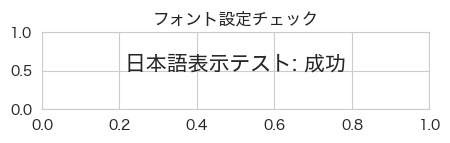

グラフ設定完了（Hiragino Sansを使用）
※もし□になっていたら、メニューの 'Kernel' -> 'Restart Kernel' を試してください


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 1. Seabornのスタイル設定（フォント設定の前に実行）
sns.set_style("whitegrid")
sns.set_palette("husl")

# 2. Macの日本語フォント設定
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False # マイナス記号の文字化け防止

# 3. 設定が反映されたか確認用のテスト描画
fig, ax = plt.subplots(figsize=(5, 1))
ax.text(0.5, 0.5, '日本語表示テスト: 成功', fontsize=15, ha='center')
ax.set_title('フォント設定チェック')
plt.show()

print("グラフ設定完了（Hiragino Sansを使用）")
print("※もし□になっていたら、メニューの 'Kernel' -> 'Restart Kernel' を試してください")

In [71]:
output_dir = Path("output")
(output_dir / "graphs").mkdir(parents=True, exist_ok=True)
(output_dir / "data").mkdir(parents=True, exist_ok=True)

print("出力ディレクトリ作成完了")

出力ディレクトリ作成完了


In [72]:
from db_manage import VacantHouseDB

db = VacantHouseDB()

with db.get_connection() as conn:
    # 空き家データ
    vacant_df = pd.read_sql_query("""
        SELECT 
            v.*,
            c.name as city_name
        FROM vacant_houses v
        JOIN city_town c ON v.c_t_code = c.code
    """, conn)
    
    # 築年数データ
    age_df = pd.read_sql_query("""
        SELECT * FROM house_age
    """, conn)

print(f"データ読み込み完了")
print(f"   - 空き家データ: {len(vacant_df)}件")
print(f"   - 築年数データ: {len(age_df)}件")

データ読み込み完了
   - 空き家データ: 16件
   - 築年数データ: 16件


In [73]:
df = vacant_df.merge(age_df, on=['c_t_code', 'year'], how='left')

print(f"データ結合完了: {len(df)}件")

データ結合完了: 16件


In [74]:
def calculate_metrics(df):
    """分析用指標を計算"""
    df = df.copy()
    
    # 1. 空き家率 (%)
    df['vacant_rate'] = (df['total_vacant'] / df['total_house'] * 100).round(2)
    
    # 2. 別荘割合 (%) - 二次的住宅 / 総空き家
    df['second_use_rate'] = (df['second_use'] / df['total_vacant'] * 100).round(2)
    
    # 3. その他空き家率 (%) - 管理不全の可能性
    df['other_vacant_rate'] = (df['other_vacant'] / df['total_vacant'] * 100).round(2)
    
    # 4. 築年数集計
    df['total_age_count'] = (
        df['pre_1970'] + df['y1971_1980'] + df['y1981_1990'] + 
        df['y1991_2000'] + df['y2001_2010'] + df['y2011_2020'] + 
        df['y2021_2023']
    )
    
    # 5. 築40年以上の割合 (%)
    df['old_house_count'] = df['pre_1970'] + df['y1971_1980']
    df['old_house_rate'] = (df['old_house_count'] / df['total_age_count'] * 100).round(2)
    
    # 6. 築50年以上の割合 (%)
    df['very_old_house_rate'] = (df['pre_1970'] / df['total_age_count'] * 100).round(2)
    
    return df

In [75]:
df = calculate_metrics(df)

print("指標計算完了")

指標計算完了


In [76]:
df_prefecture = df[df['c_t_code'] == '19000'].copy()
df_cities = df[df['c_t_code'] != '19000'].copy()

print(f"データ分離完了")
print(f"   - 県全体データ: {len(df_prefecture)}件")
print(f"   - 市町村データ: {len(df_cities)}件")
print(f"\n 市町村数: {df_cities['city_name'].nunique()}市町村")

データ分離完了
   - 県全体データ: 1件
   - 市町村データ: 15件

 市町村数: 15市町村


In [77]:
print("="*70)
print("【基本統計量】")
print("="*70)

print("\n空き家率 (%)")
print(f"   平均: {df_cities['vacant_rate'].mean():.2f}%")
print(f"   中央値: {df_cities['vacant_rate'].median():.2f}%")
print(f"   最小値: {df_cities['vacant_rate'].min():.2f}%")
print(f"   最大値: {df_cities['vacant_rate'].max():.2f}%")

print("\n別荘割合 (%)")
print(f"   平均: {df_cities['second_use_rate'].mean():.2f}%")
print(f"   中央値: {df_cities['second_use_rate'].median():.2f}%")
print(f"   最小値: {df_cities['second_use_rate'].min():.2f}%")
print(f"   最大値: {df_cities['second_use_rate'].max():.2f}%")

print("\n築40年以上住宅割合 (%)")
print(f"   平均: {df_cities['old_house_rate'].mean():.2f}%")
print(f"   中央値: {df_cities['old_house_rate'].median():.2f}%")
print(f"   最小値: {df_cities['old_house_rate'].min():.2f}%")
print(f"   最大値: {df_cities['old_house_rate'].max():.2f}%")

【基本統計量】

空き家率 (%)
   平均: 18.82%
   中央値: 17.44%
   最小値: 12.20%
   最大値: 46.06%

別荘割合 (%)
   平均: 7.95%
   中央値: 3.21%
   最小値: 0.92%
   最大値: 68.48%

築40年以上住宅割合 (%)
   平均: 21.47%
   中央値: 19.12%
   最小値: 10.25%
   最大値: 35.79%


In [78]:
print("\n" + "="*70)
print("【外れ値の検出】")
print("="*70)

# 四分位範囲（IQR）法で外れ値を検出
Q1_vacant = df_cities['vacant_rate'].quantile(0.25)
Q3_vacant = df_cities['vacant_rate'].quantile(0.75)
IQR_vacant = Q3_vacant - Q1_vacant
outlier_threshold = Q3_vacant + 1.5 * IQR_vacant

print(f"\n空き家率の外れ値判定:")
print(f"   第1四分位数（Q1）: {Q1_vacant:.2f}%")
print(f"   第3四分位数（Q3）: {Q3_vacant:.2f}%")
print(f"   四分位範囲（IQR）: {IQR_vacant:.2f}%")
print(f"   外れ値の閾値: {outlier_threshold:.2f}%")

# 外れ値の市町村を特定
outliers = df_cities[df_cities['vacant_rate'] > outlier_threshold]

if len(outliers) > 0:
    print(f"\n外れ値として検出された市町村: {len(outliers)}件")
    for _, row in outliers.iterrows():
        print(f"\n   【{row['city_name']}】")
        print(f"      空き家率: {row['vacant_rate']:.2f}%")
        print(f"      別荘割合: {row['second_use_rate']:.2f}%")
        print(f"      築40年以上: {row['old_house_rate']:.2f}%")
        print(f"      → 別荘地として特異的な特性を持つ")
else:
    print("\n外れ値は検出されませんでした")


【外れ値の検出】

空き家率の外れ値判定:
   第1四分位数（Q1）: 14.28%
   第3四分位数（Q3）: 19.59%
   四分位範囲（IQR）: 5.31%
   外れ値の閾値: 27.55%

外れ値として検出された市町村: 1件

   【北杜市】
      空き家率: 46.06%
      別荘割合: 68.48%
      築40年以上: 23.30%
      → 別荘地として特異的な特性を持つ


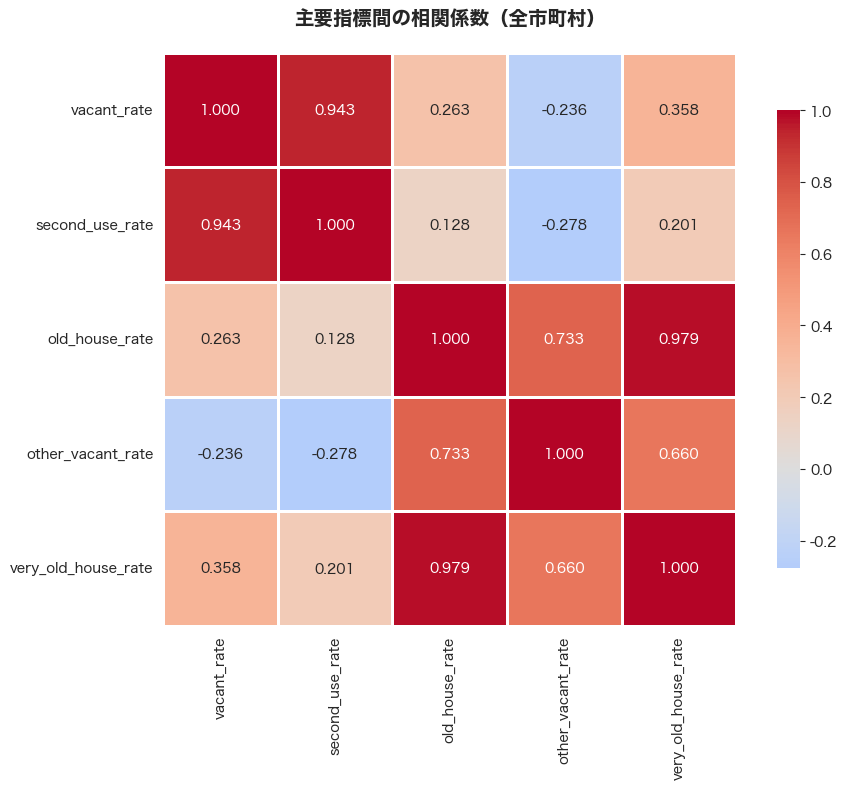

相関マトリックス（全データ）を保存しました


In [79]:
correlation_cols = ['vacant_rate', 'second_use_rate', 'old_house_rate', 
                    'other_vacant_rate', 'very_old_house_rate']

correlation_matrix = df_cities[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('主要指標間の相関係数（全市町村）', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('output/graphs/00_correlation_matrix_all.png', dpi=300, bbox_inches='tight')
plt.show()

print("相関マトリックス（全データ）を保存しました")

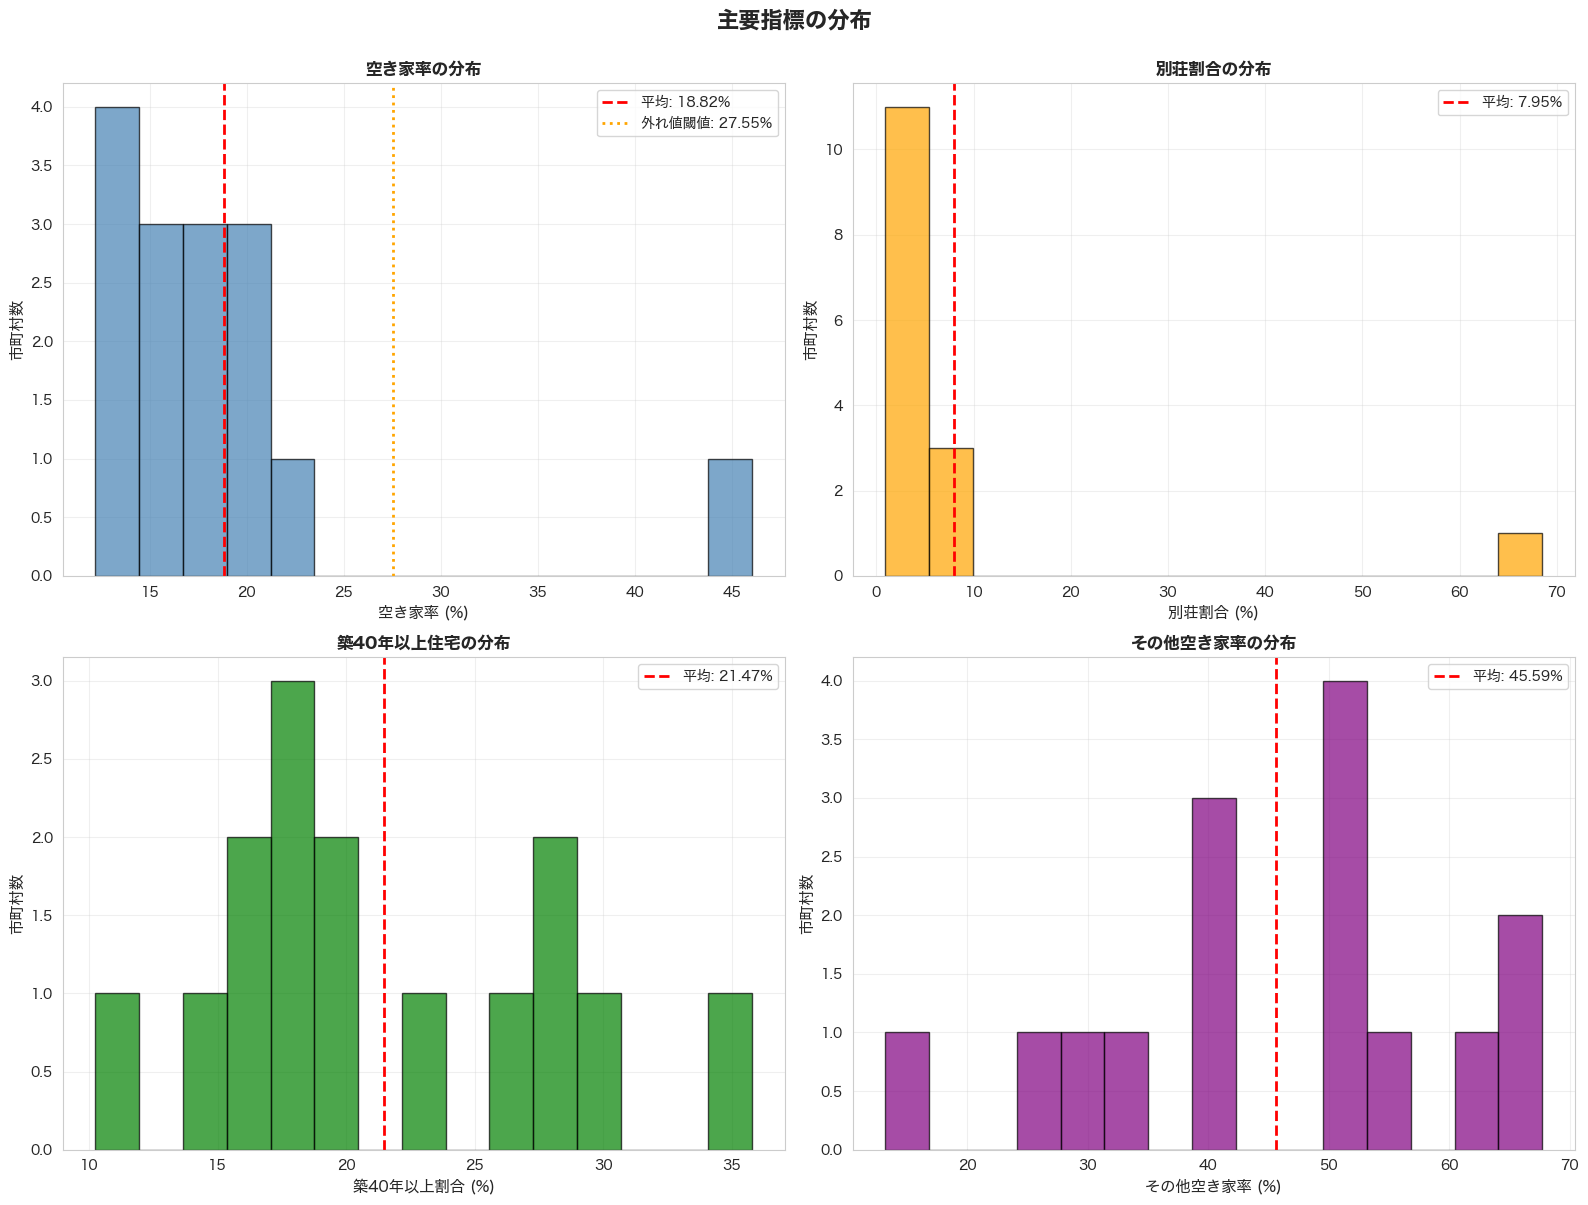

分布グラフを保存しました


In [80]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# 1. 空き家率
axes[0].hist(df_cities['vacant_rate'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('空き家率 (%)', fontsize=11)
axes[0].set_ylabel('市町村数', fontsize=11)
axes[0].set_title('空き家率の分布', fontsize=12, fontweight='bold')
axes[0].axvline(df_cities['vacant_rate'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'平均: {df_cities["vacant_rate"].mean():.2f}%')
axes[0].axvline(outlier_threshold, color='orange', linestyle=':', 
                linewidth=2, label=f'外れ値閾値: {outlier_threshold:.2f}%')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 別荘割合
axes[1].hist(df_cities['second_use_rate'], bins=15, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('別荘割合 (%)', fontsize=11)
axes[1].set_ylabel('市町村数', fontsize=11)
axes[1].set_title('別荘割合の分布', fontsize=12, fontweight='bold')
axes[1].axvline(df_cities['second_use_rate'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'平均: {df_cities["second_use_rate"].mean():.2f}%')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. 築40年以上割合
axes[2].hist(df_cities['old_house_rate'], bins=15, edgecolor='black', alpha=0.7, color='green')
axes[2].set_xlabel('築40年以上割合 (%)', fontsize=11)
axes[2].set_ylabel('市町村数', fontsize=11)
axes[2].set_title('築40年以上住宅の分布', fontsize=12, fontweight='bold')
axes[2].axvline(df_cities['old_house_rate'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'平均: {df_cities["old_house_rate"].mean():.2f}%')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 4. その他空き家率
axes[3].hist(df_cities['other_vacant_rate'], bins=15, edgecolor='black', alpha=0.7, color='purple')
axes[3].set_xlabel('その他空き家率 (%)', fontsize=11)
axes[3].set_ylabel('市町村数', fontsize=11)
axes[3].set_title('その他空き家率の分布', fontsize=12, fontweight='bold')
axes[3].axvline(df_cities['other_vacant_rate'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'平均: {df_cities["other_vacant_rate"].mean():.2f}%')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.suptitle('主要指標の分布', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('output/graphs/01_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("分布グラフを保存しました")

In [81]:
print("="*70)
print("【空き家率トップ10】")
print("="*70)

top10 = df_cities.nlargest(10, 'vacant_rate')[
    ['city_name', 'vacant_rate', 'second_use_rate', 'old_house_rate', 
     'other_vacant_rate', 'total_house', 'total_vacant']
].copy()

top10.index = range(1, 11)
print(top10.to_string())

# ==========================================
# 仮説1: 築40年以上の住宅割合が高い市町村ほど空き家率が高い
# ==========================================

【空き家率トップ10】
   city_name  vacant_rate  second_use_rate  old_house_rate  other_vacant_rate  total_house  total_vacant
1        北杜市        46.06            68.48           23.30              25.59        35890         16530
2        大月市        22.05             6.30           35.79              67.72        11520          2540
3       上野原市        21.19             4.69           27.84              49.61        12080          2560
4        山梨市        19.70             6.58           29.14              66.14        16190          3190
5        昭和町        19.47             1.28           10.25              13.19        12070          2350
6        笛吹市        18.20             5.23           17.64              51.47        33630          6120
7        甲府市        18.14             1.35           20.01              39.68       106290         19280
8        甲州市        17.44             2.17           28.75              60.87        13190          2300
9     富士河口湖町        16.09             9.52 

In [82]:
print("\n" + "="*70)
print("【仮説1】築40年以上の住宅割合が高い市町村ほど空き家率が高い")
print("="*70)

# 分析用データ（欠損値除外）
df_h1 = df_cities[['old_house_rate', 'vacant_rate', 'city_name', 'c_t_code']].dropna()

print(f"\n分析対象: {len(df_h1)}市町村")

# 相関係数を計算
correlation_h1 = df_h1['old_house_rate'].corr(df_h1['vacant_rate'])
print(f"\n相関係数（全データ）: {correlation_h1:.3f}")

if abs(correlation_h1) > 0.7:
    print("   → 強い相関")
elif abs(correlation_h1) > 0.4:
    print("   → 中程度の相関")
elif abs(correlation_h1) > 0.2:
    print("   → 弱い相関")
else:
    print("   → ほぼ相関なし")


【仮説1】築40年以上の住宅割合が高い市町村ほど空き家率が高い

分析対象: 15市町村

相関係数（全データ）: 0.263
   → 弱い相関


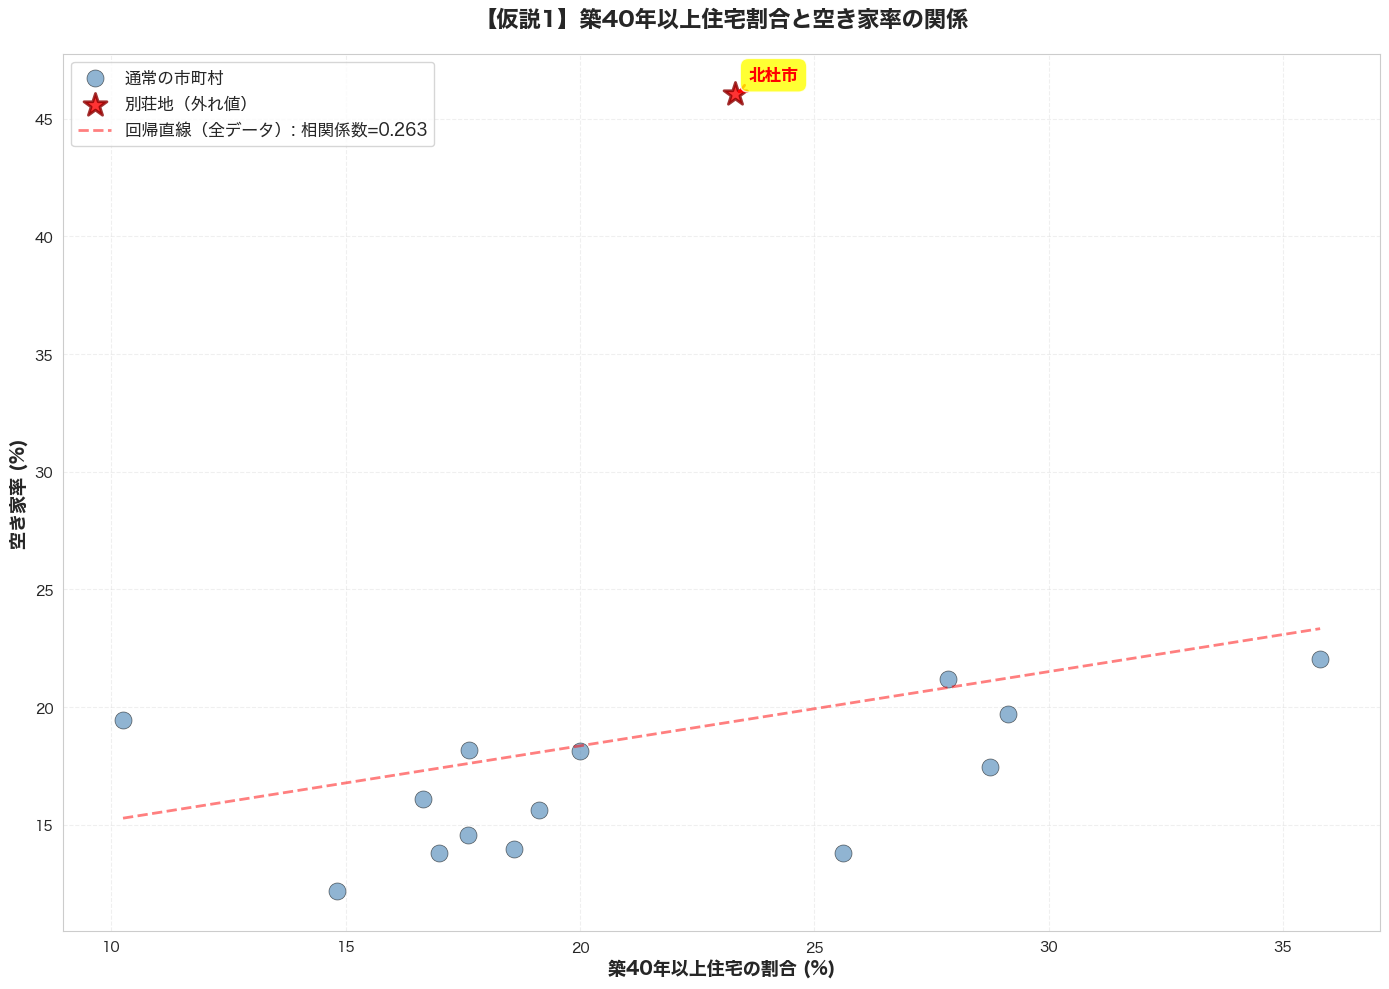

散布図を保存しました


In [83]:
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(14, 10))

# 通常の市町村
normal_cities = df_h1[~df_h1['city_name'].isin(outliers['city_name'])]
ax.scatter(normal_cities['old_house_rate'], normal_cities['vacant_rate'], 
           s=150, alpha=0.6, c='steelblue', 
           edgecolors='black', linewidth=0.5, label='通常の市町村')

# 外れ値（別荘地）
if len(outliers) > 0:
    outlier_data = df_h1[df_h1['city_name'].isin(outliers['city_name'])]
    ax.scatter(outlier_data['old_house_rate'], outlier_data['vacant_rate'], 
               s=300, alpha=0.8, c='red', marker='*',
               edgecolors='darkred', linewidth=2, label='別荘地（外れ値）')
    
    # 外れ値にラベル
    for _, row in outlier_data.iterrows():
        ax.annotate(row['city_name'], 
                    xy=(row['old_house_rate'], row['vacant_rate']),
                    xytext=(10, 10), textcoords='offset points', 
                    fontsize=12, fontweight='bold', color='red',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=2, color='red'))

# 回帰直線（全データ）
slope, intercept, r_value, _, _ = linregress(df_h1['old_house_rate'], df_h1['vacant_rate'])
x_line = np.linspace(df_h1['old_house_rate'].min(), df_h1['old_house_rate'].max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.5,
        label=f'回帰直線（全データ）: 相関係数={correlation_h1:.3f}')

ax.set_xlabel('築40年以上住宅の割合 (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('空き家率 (%)', fontsize=13, fontweight='bold')
ax.set_title('【仮説1】築40年以上住宅割合と空き家率の関係', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('output/graphs/02_hypothesis1_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("散布図を保存しました")

In [84]:
print("="*70)
print("【仮説1: 分析結果】")
print("="*70)

print(f"\n相関分析（全データ）")
print(f"   相関係数: {correlation_h1:.3f}")

print(f"\n回帰分析")
print(f"   回帰式: 空き家率 = {slope:.2f} × 築40年以上割合 + {intercept:.2f}")
print(f"   決定係数（R²）: {r_value**2:.3f}")

print(f"\n 仮説1の結論")
print(f"   築40年以上の住宅割合と空き家率の相関は弱い（相関係数: {correlation_h1:.3f}）")
print(f"   → 築年数だけでは空き家率を説明できない")
print(f"   → 他の要因（別荘、人口動態など）の影響が大きい可能性")

# ==========================================
# 仮説2: 別荘の管理不全が空き家率を押し上げている
# ==========================================

【仮説1: 分析結果】

相関分析（全データ）
   相関係数: 0.263

回帰分析
   回帰式: 空き家率 = 0.32 × 築40年以上割合 + 12.06
   決定係数（R²）: 0.069

 仮説1の結論
   築40年以上の住宅割合と空き家率の相関は弱い（相関係数: 0.263）
   → 築年数だけでは空き家率を説明できない
   → 他の要因（別荘、人口動態など）の影響が大きい可能性


In [85]:
print("\n" + "="*70)
print("【仮説2】別荘の管理不全が空き家率を押し上げている")
print("="*70)

# 分析用データ（欠損値除外）
df_h2 = df_cities[['second_use_rate', 'vacant_rate', 'city_name', 'c_t_code']].dropna()

print(f"\n分析対象: {len(df_h2)}市町村")

# 相関係数を計算（全データ）
correlation_h2_all = df_h2['second_use_rate'].corr(df_h2['vacant_rate'])
print(f"\n相関係数（全データ）: {correlation_h2_all:.3f}")

# 外れ値を除いた相関係数
df_h2_no_outlier = df_h2[~df_h2['city_name'].isin(outliers['city_name'])]
correlation_h2_no_outlier = df_h2_no_outlier['second_use_rate'].corr(df_h2_no_outlier['vacant_rate'])
print(f"相関係数（外れ値除外）: {correlation_h2_no_outlier:.3f}")

print(f"\n 外れ値の影響:")
print(f"   全データの相関係数: {correlation_h2_all:.3f}")
print(f"   外れ値除外後の相関係数: {correlation_h2_no_outlier:.3f}")
print(f"   → 外れ値（別荘地）が相関を{correlation_h2_all - correlation_h2_no_outlier:.3f}押し上げている")


【仮説2】別荘の管理不全が空き家率を押し上げている

分析対象: 15市町村

相関係数（全データ）: 0.943
相関係数（外れ値除外）: 0.391

 外れ値の影響:
   全データの相関係数: 0.943
   外れ値除外後の相関係数: 0.391
   → 外れ値（別荘地）が相関を0.551押し上げている


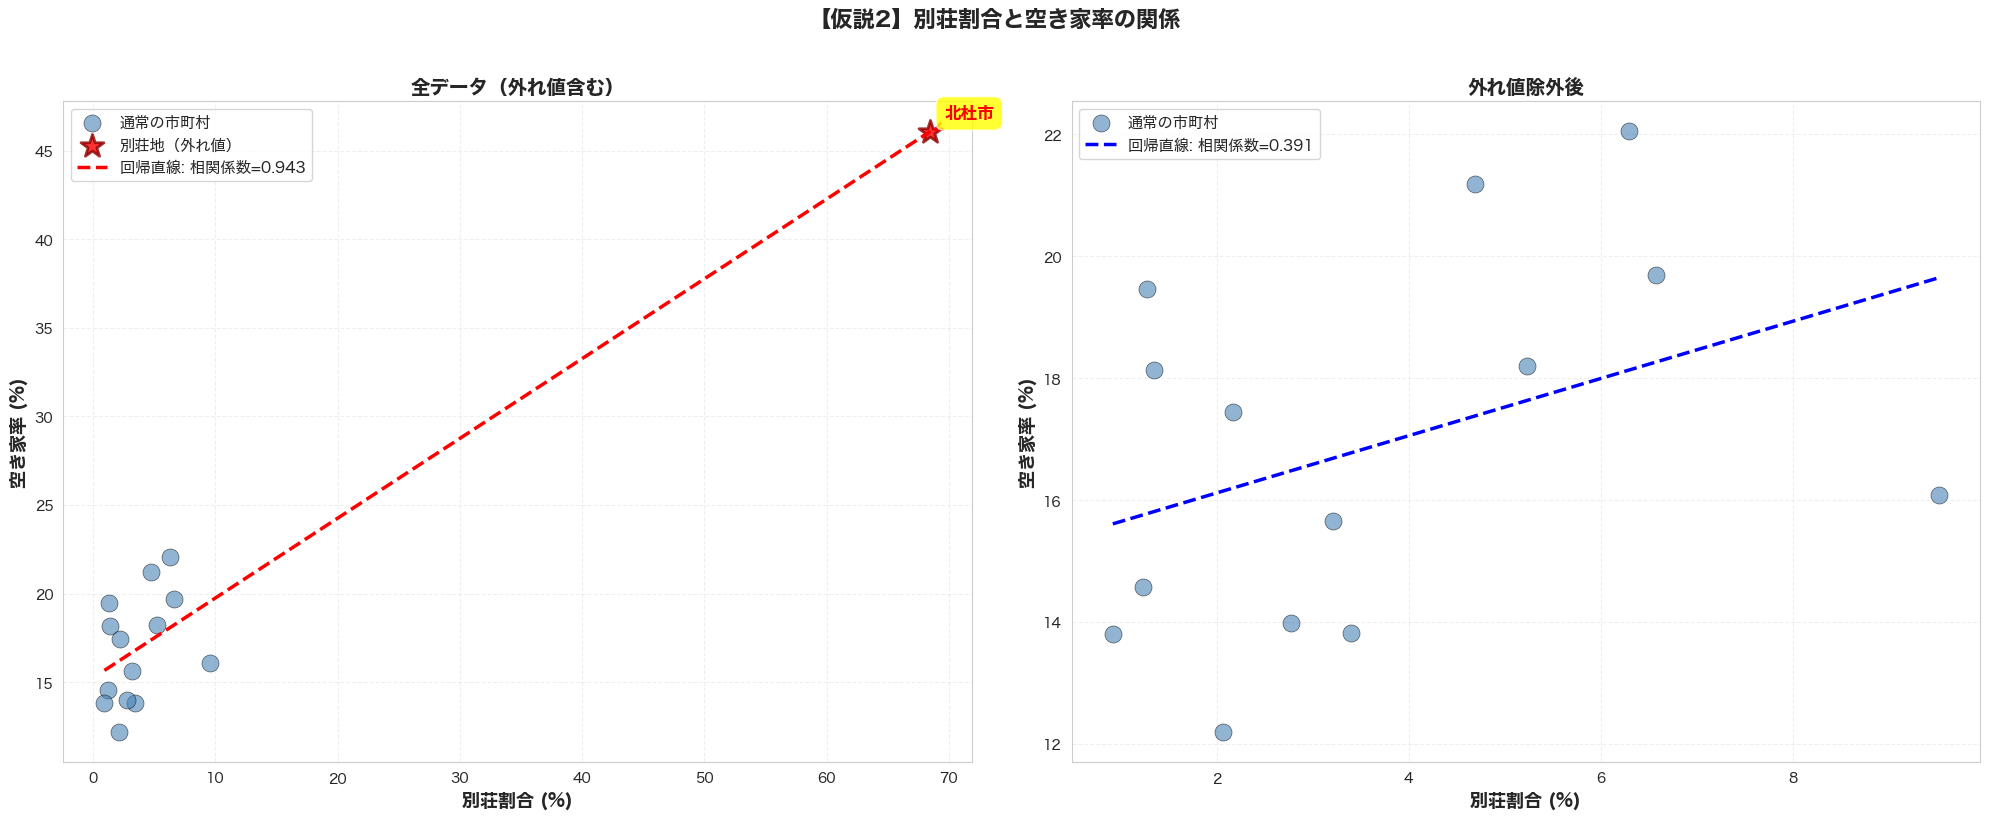

散布図（比較版）を保存しました


In [86]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 左: 全データ
ax1 = axes[0]
normal_cities_h2 = df_h2[~df_h2['city_name'].isin(outliers['city_name'])]
ax1.scatter(normal_cities_h2['second_use_rate'], normal_cities_h2['vacant_rate'], 
            s=150, alpha=0.6, c='steelblue', 
            edgecolors='black', linewidth=0.5, label='通常の市町村')

if len(outliers) > 0:
    outlier_data_h2 = df_h2[df_h2['city_name'].isin(outliers['city_name'])]
    ax1.scatter(outlier_data_h2['second_use_rate'], outlier_data_h2['vacant_rate'], 
                s=300, alpha=0.8, c='red', marker='*',
                edgecolors='darkred', linewidth=2, label='別荘地（外れ値）')
    
    for _, row in outlier_data_h2.iterrows():
        ax1.annotate(row['city_name'], 
                     xy=(row['second_use_rate'], row['vacant_rate']),
                     xytext=(10, 10), textcoords='offset points', 
                     fontsize=12, fontweight='bold', color='red',
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                     arrowprops=dict(arrowstyle='->', lw=2, color='red'))

slope2_all, intercept2_all, r_value2_all, _, _ = linregress(
    df_h2['second_use_rate'], df_h2['vacant_rate'])
x_line2 = np.linspace(df_h2['second_use_rate'].min(), df_h2['second_use_rate'].max(), 100)
y_line2 = slope2_all * x_line2 + intercept2_all
ax1.plot(x_line2, y_line2, 'r--', linewidth=2.5, 
         label=f'回帰直線: 相関係数={correlation_h2_all:.3f}')

ax1.set_xlabel('別荘割合 (%)', fontsize=13, fontweight='bold')
ax1.set_ylabel('空き家率 (%)', fontsize=13, fontweight='bold')
ax1.set_title('全データ（外れ値含む）', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle='--')

# 右: 外れ値除外
ax2 = axes[1]
ax2.scatter(df_h2_no_outlier['second_use_rate'], df_h2_no_outlier['vacant_rate'], 
            s=150, alpha=0.6, c='steelblue', 
            edgecolors='black', linewidth=0.5, label='通常の市町村')

slope2_no, intercept2_no, r_value2_no, _, _ = linregress(
    df_h2_no_outlier['second_use_rate'], df_h2_no_outlier['vacant_rate'])
x_line2_no = np.linspace(df_h2_no_outlier['second_use_rate'].min(), 
                         df_h2_no_outlier['second_use_rate'].max(), 100)
y_line2_no = slope2_no * x_line2_no + intercept2_no
ax2.plot(x_line2_no, y_line2_no, 'b--', linewidth=2.5, 
         label=f'回帰直線: 相関係数={correlation_h2_no_outlier:.3f}')

ax2.set_xlabel('別荘割合 (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('空き家率 (%)', fontsize=13, fontweight='bold')
ax2.set_title('外れ値除外後', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('【仮説2】別荘割合と空き家率の関係', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/graphs/03_hypothesis2_scatter_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("散布図（比較版）を保存しました")

In [87]:
# 別荘割合の中央値でグループ分割（外れ値除外後）
median_second = df_h2_no_outlier['second_use_rate'].median()

df_h2_no_outlier_copy = df_h2_no_outlier.copy()
df_h2_no_outlier_copy['second_group'] = df_h2_no_outlier_copy['second_use_rate'].apply(
    lambda x: '高別荘率' if x > median_second else '低別荘率'
)

print(f"\nグループ分割（外れ値除外後）")
print(f"   別荘割合の中央値: {median_second:.2f}%")
print(f"   高別荘率グループ: {(df_h2_no_outlier_copy['second_group'] == '高別荘率').sum()}市町村")
print(f"   低別荘率グループ: {(df_h2_no_outlier_copy['second_group'] == '低別荘率').sum()}市町村")


グループ分割（外れ値除外後）
   別荘割合の中央値: 3.00%
   高別荘率グループ: 7市町村
   低別荘率グループ: 7市町村


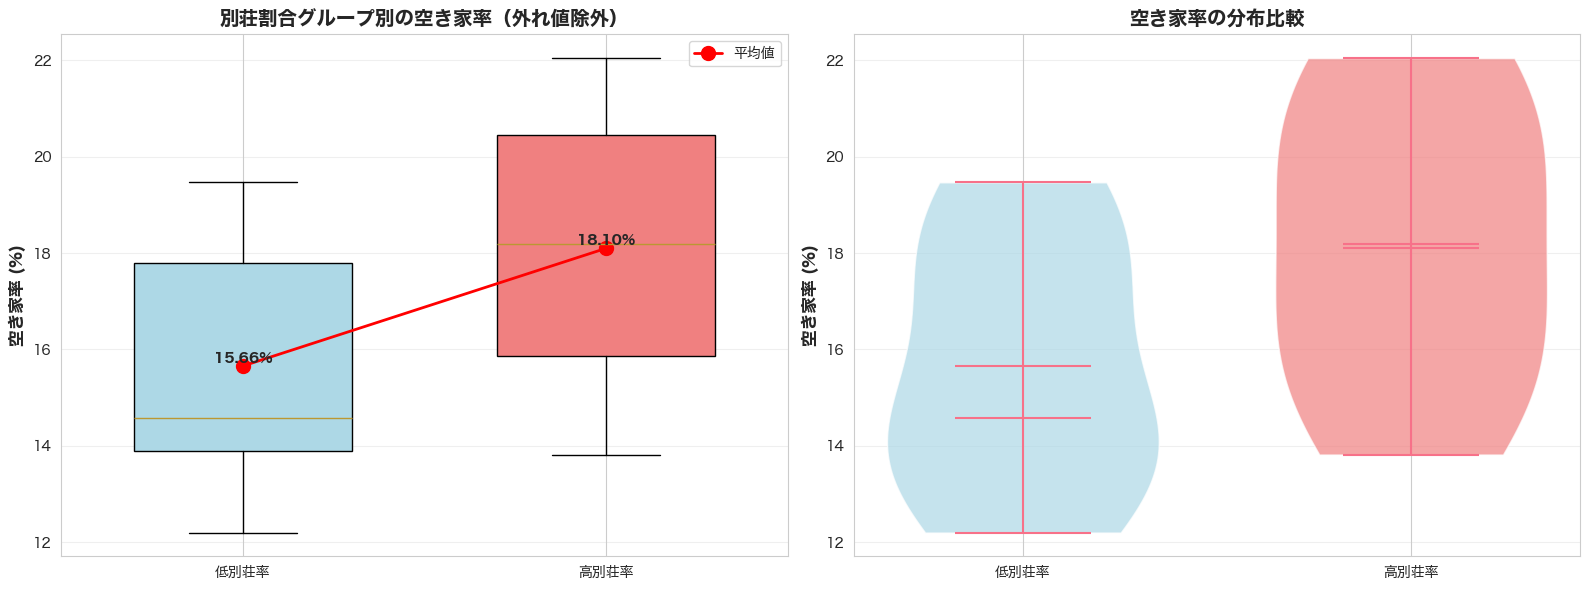

グループ比較グラフを保存しました


In [88]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# データ準備
high_second = df_h2_no_outlier_copy[df_h2_no_outlier_copy['second_group'] == '高別荘率']['vacant_rate']
low_second = df_h2_no_outlier_copy[df_h2_no_outlier_copy['second_group'] == '低別荘率']['vacant_rate']

# 1. 箱ひげ図
bp = axes[0].boxplot([low_second, high_second], 
                      labels=['低別荘率', '高別荘率'],
                      patch_artist=True,
                      widths=0.6)

colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

axes[0].set_ylabel('空き家率 (%)', fontsize=12, fontweight='bold')
axes[0].set_title('別荘割合グループ別の空き家率（外れ値除外）', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

means = [low_second.mean(), high_second.mean()]
axes[0].plot([1, 2], means, 'ro-', linewidth=2, markersize=10, label='平均値')
for i, mean in enumerate(means, 1):
    axes[0].text(i, mean, f'{mean:.2f}%', ha='center', va='bottom', fontweight='bold')
axes[0].legend()

# 2. バイオリンプロット
parts = axes[1].violinplot([low_second, high_second], 
                           positions=[1, 2], 
                           showmeans=True, 
                           showmedians=True,
                           widths=0.7)

for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['低別荘率', '高別荘率'])
axes[1].set_ylabel('空き家率 (%)', fontsize=12, fontweight='bold')
axes[1].set_title('空き家率の分布比較', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('output/graphs/04_hypothesis2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("グループ比較グラフを保存しました")

In [89]:
print("="*70)
print("【仮説2: 分析結果】")
print("="*70)

print(f"\n相関分析")
print(f"   全データの相関係数: {correlation_h2_all:.3f}")
print(f"   外れ値除外後の相関係数: {correlation_h2_no_outlier:.3f}")

print(f"\n 回帰分析（外れ値除外後）")
print(f"   回帰式: 空き家率 = {slope2_no:.2f} × 別荘割合 + {intercept2_no:.2f}")
print(f"   決定係数（R²）: {r_value2_no**2:.3f}")

print(f"\nグループ間比較（外れ値除外後）")
print(f"   低別荘率グループの平均空き家率: {low_second.mean():.2f}%")
print(f"   高別荘率グループの平均空き家率: {high_second.mean():.2f}%")
print(f"   差: {high_second.mean() - low_second.mean():.2f}%")

print(f"\n 解釈")
print(f"   【全データ】")
print(f"   - 相関係数0.94は北杜市（別荘地）の影響で非常に高くなっている")
print(f"   - 北杜市: 空き家率46.06%、別荘割合68.48%")
print(f"")
print(f"   【外れ値除外後】")
print(f"   - 一般的な市町村でも別荘割合と空き家率には相関がある（相関係数: {correlation_h2_no_outlier:.3f}）")
print(f"   - 別荘割合が1%増えると、空き家率は約{slope2_no:.2f}%増える傾向")

print(f"\n仮説2の結論")
print(f"   別荘割合と空き家率には明確な関係がある")
print(f"   特に別荘地（北杜市など）では別荘問題が深刻")
print(f"   一般的な市町村でも別荘割合が高いほど空き家率が高い傾向")
print(f"   → 別荘の管理不全が空き家問題の重要な要因の1つ")

# ==========================================
# 地域分類と価値提案
# ==========================================

【仮説2: 分析結果】

相関分析
   全データの相関係数: 0.943
   外れ値除外後の相関係数: 0.391

 回帰分析（外れ値除外後）
   回帰式: 空き家率 = 0.47 × 別荘割合 + 15.18
   決定係数（R²）: 0.153

グループ間比較（外れ値除外後）
   低別荘率グループの平均空き家率: 15.66%
   高別荘率グループの平均空き家率: 18.10%
   差: 2.44%

 解釈
   【全データ】
   - 相関係数0.94は北杜市（別荘地）の影響で非常に高くなっている
   - 北杜市: 空き家率46.06%、別荘割合68.48%

   【外れ値除外後】
   - 一般的な市町村でも別荘割合と空き家率には相関がある（相関係数: 0.391）
   - 別荘割合が1%増えると、空き家率は約0.47%増える傾向

仮説2の結論
   別荘割合と空き家率には明確な関係がある
   特に別荘地（北杜市など）では別荘問題が深刻
   一般的な市町村でも別荘割合が高いほど空き家率が高い傾向
   → 別荘の管理不全が空き家問題の重要な要因の1つ


In [90]:
print("\n" + "="*70)
print("【地域の特性分類】")
print("="*70)

def classify_area_advanced(row, outliers_list):
    """地域の特性を分類（外れ値を考慮）"""
    # 外れ値（別荘地）
    if row['city_name'] in outliers_list['city_name'].values:
        return '別荘地（特別対策必要）'
    
    # 通常の市町村
    second_median = df_h2_no_outlier['second_use_rate'].median()
    old_median = df_cities[~df_cities['city_name'].isin(outliers_list['city_name'])]['old_house_rate'].median()
    
    old_high = row['old_house_rate'] > old_median
    second_high = row['second_use_rate'] > second_median
    
    if old_high and second_high:
        return '両方の問題あり'
    elif old_high:
        return '築年数問題'
    elif second_high:
        return '別荘問題'
    else:
        return '比較的良好'

df_cities['area_type'] = df_cities.apply(lambda row: classify_area_advanced(row, outliers), axis=1)

# 各タイプの統計
print(f"\n地域タイプ別の統計")
for area_type in ['別荘地（特別対策必要）', '両方の問題あり', '築年数問題', '別荘問題', '比較的良好']:
    subset = df_cities[df_cities['area_type'] == area_type]
    if len(subset) == 0:
        continue
    cities = subset['city_name'].tolist()
    
    print(f"\n【{area_type}】")
    print(f"   市町村数: {len(cities)}")
    print(f"   平均空き家率: {subset['vacant_rate'].mean():.2f}%")
    print(f"   平均築40年以上割合: {subset['old_house_rate'].mean():.2f}%")
    print(f"   平均別荘割合: {subset['second_use_rate'].mean():.2f}%")
    print(f"   該当市町村: {', '.join(cities)}")


【地域の特性分類】

地域タイプ別の統計

【別荘地（特別対策必要）】
   市町村数: 1
   平均空き家率: 46.06%
   平均築40年以上割合: 23.30%
   平均別荘割合: 68.48%
   該当市町村: 北杜市

【両方の問題あり】
   市町村数: 5
   平均空き家率: 18.48%
   平均築40年以上割合: 27.50%
   平均別荘割合: 4.84%
   該当市町村: 富士吉田市, 山梨市, 大月市, 韮崎市, 上野原市

【築年数問題】
   市町村数: 2
   平均空き家率: 17.79%
   平均築40年以上割合: 24.38%
   平均別荘割合: 1.76%
   該当市町村: 甲府市, 甲州市

【別荘問題】
   市町村数: 2
   平均空き家率: 17.14%
   平均築40年以上割合: 17.14%
   平均別荘割合: 7.38%
   該当市町村: 笛吹市, 富士河口湖町

【比較的良好】
   市町村数: 5
   平均空き家率: 14.81%
   平均築40年以上割合: 15.65%
   平均別荘割合: 1.66%
   該当市町村: 都留市, 南アルプス市, 甲斐市, 中央市, 昭和町


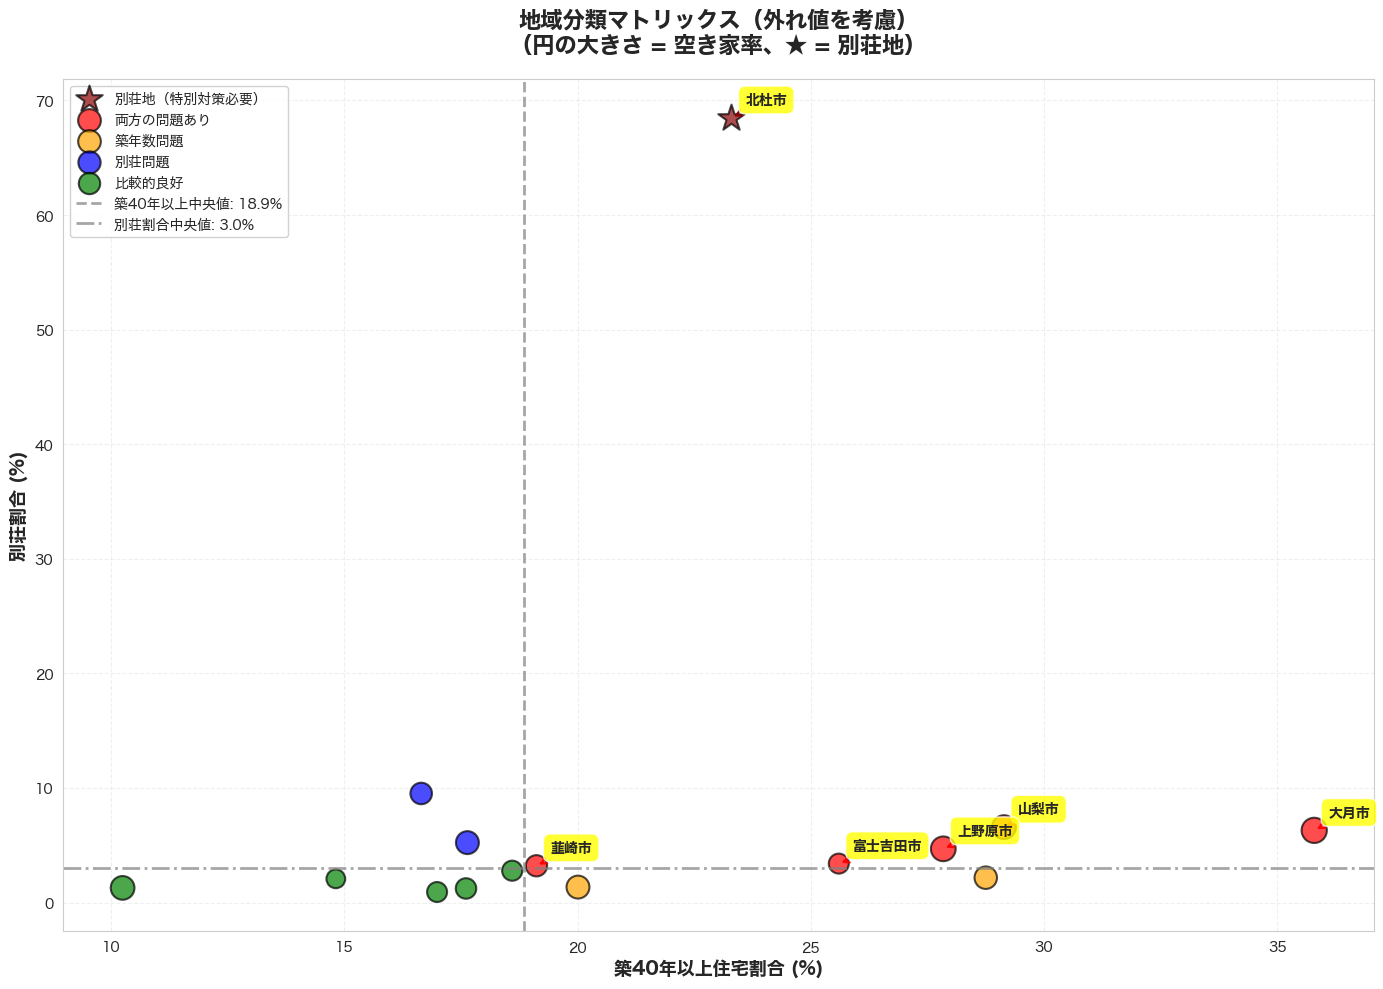

地域分類マトリックスを保存しました


In [91]:
fig, ax = plt.subplots(figsize=(14, 10))

# 地域タイプ別に色分け
area_colors = {
    '別荘地（特別対策必要）': 'darkred',
    '両方の問題あり': 'red',
    '築年数問題': 'orange',
    '別荘問題': 'blue',
    '比較的良好': 'green'
}

for area_type, color in area_colors.items():
    subset = df_cities[df_cities['area_type'] == area_type]
    if len(subset) == 0:
        continue
    
    marker = '*' if area_type == '別荘地（特別対策必要）' else 'o'
    size = 400 if area_type == '別荘地（特別対策必要）' else subset['vacant_rate']*15
    
    ax.scatter(subset['old_house_rate'], subset['second_use_rate'], 
               s=size, c=color, alpha=0.7, marker=marker,
               edgecolors='black', linewidth=1.5, label=area_type)

# 中央値で十字線（外れ値除外後）
median_old = df_cities[~df_cities['city_name'].isin(outliers['city_name'])]['old_house_rate'].median()
median_second = df_h2_no_outlier['second_use_rate'].median()

ax.axvline(median_old, color='gray', linestyle='--', linewidth=2, alpha=0.7,
           label=f'築40年以上中央値: {median_old:.1f}%')
ax.axhline(median_second, color='gray', linestyle='-.', linewidth=2, alpha=0.7,
           label=f'別荘割合中央値: {median_second:.1f}%')

# ラベル（別荘地と両方の問題がある地域）
critical = df_cities[df_cities['area_type'].isin(['別荘地（特別対策必要）', '両方の問題あり'])]
for _, row in critical.iterrows():
    color = 'darkred' if row['area_type'] == '別荘地（特別対策必要）' else 'red'
    ax.annotate(row['city_name'], 
                xy=(row['old_house_rate'], row['second_use_rate']),
                xytext=(10, 10), textcoords='offset points', 
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color))

ax.set_xlabel('築40年以上住宅割合 (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('別荘割合 (%)', fontsize=13, fontweight='bold')
ax.set_title('地域分類マトリックス（外れ値を考慮）\n（円の大きさ = 空き家率、★ = 別荘地）', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('output/graphs/05_area_classification.png', dpi=300, bbox_inches='tight')
plt.show()

print("地域分類マトリックスを保存しました")

# ==========================================
# 価値提案
# ==========================================

In [92]:
df_cities_export = df_cities[[
    'c_t_code', 'city_name', 'year',
    'total_house', 'total_vacant', 
    'vacant_rate', 'second_use_rate', 'old_house_rate', 
    'other_vacant_rate', 'very_old_house_rate',
    'area_type'
]].copy()

df_cities_export.to_csv('output/data/city_analysis_result.csv', 
                        index=False, encoding='utf-8-sig')
print("市町村別データを保存: output/data/city_analysis_result.csv")

# 地域タイプ別サマリー
area_summary = df_cities.groupby('area_type').agg({
    'city_name': 'count',
    'vacant_rate': ['mean', 'std', 'min', 'max'],
    'old_house_rate': ['mean', 'std'],
    'second_use_rate': ['mean', 'std']
}).round(2)

area_summary.to_csv('output/data/area_type_summary.csv', encoding='utf-8-sig')
print("地域タイプ別サマリーを保存: output/data/area_type_summary.csv")

print("\n 全ての分析結果をエクスポートしました")

市町村別データを保存: output/data/city_analysis_result.csv
地域タイプ別サマリーを保存: output/data/area_type_summary.csv

 全ての分析結果をエクスポートしました
